**PySpark Setup**

**Extract Spark/Hadoop and install Python dependencies**

In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
###!@0 END INIT ENVIRONMENT

**Spark Session & Load Data**

**Standard initialization for the Spark session within colab**

In [2]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("StockPrediction")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

**Load Data**

In [3]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from glob import glob

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.sql import functions
from pyspark.sql.functions import input_file_name, substring, regexp_extract, col
import pandas as pd
import ast
import re

from pyspark.sql.functions import col

In [4]:
schema = StructType([StructField("date",TimestampType(),True),
                     StructField("open",DoubleType(),True),
                     StructField("high",DoubleType(),True),
                     StructField("low",DoubleType(),True),
                     StructField("close",DoubleType(),True),
                     StructField("volume",DoubleType(),True)])

**Stock hourly Data -**

In [ ]:
Stock_DataPath = "/content/drive/MyDrive/DE_Project/hourly-data/*.txt"
Nifty50_Stock_DataPath = "/content/drive/MyDrive/DE_Project/company_data/*.txt"
nifty50_stocks = "/content/drive/MyDrive/DE_Project/ind_nifty50list.csv"
file_list = glob(Stock_DataPath)
Nifty50file_list = glob(Nifty50_Stock_DataPath)
print(f"Total number of companies data: {len(file_list)}")
print(f"Total number of companies data: {len(Nifty50file_list)}")

**Read data into Dataframe with file names also as an**

In [31]:
company_df = spark.read.csv("/content/drive/MyDrive/DE_Project/trading-industry-2.csv", header=True, inferSchema=True)
company_df = company_df.filter((col("delisted") == False) & (col("delisted").isNotNull()))
company_df = company_df.drop("name")
company_df.printSchema()
company_df.show()

root
 |-- macro: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- basicIndustry: string (nullable = true)
 |-- delisted: string (nullable = true)
 |-- isETFSec: string (nullable = true)
 |-- tradingindex: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------+--------+------------+
|               macro|              sector|            industry|       basicIndustry|delisted|isETFSec|tradingindex|
+--------------------+--------------------+--------------------+--------------------+--------+--------+------------+
|            Services|            Services|Commercial Servic...|Diversified Comme...|   False|   False|     CMSINFO|
|              Energy|Oil Gas & Consuma...|    Consumable Fuels|                Coal|   False|   False|   COALINDIA|
|Fast Moving Consu...|Fast Moving Consu...|       Food Products|             Seafood|   False|   False|   COASTCORP|
|       

In [32]:
instrument_data_path = "/content/drive/MyDrive/DE_Project/instruments-data.txt"

data = []
eq_search_pattern = r"'instrument_type': 'EQ'"
bse_search_pattern = r"'exchange': 'BSE'"
name_search_pattern = r"name':\s*'([^']+)'"

import json

instrument_data = pd.DataFrame(columns=["instrument_token", "exchange_token",
                                        "tradingsymbol"])
eq_data = []

with open(instrument_data_path, 'r') as instruments_data_f:
    for data_str in instruments_data_f:
      bse_match= re.search(bse_search_pattern, data_str)
      if bse_match:
          equity_match = re.search(eq_search_pattern, data_str)
          if equity_match:
              name_match = re.search(name_search_pattern, data_str)
              if name_match:
                  name = name_match.group(1)

                  # Find the position of 'datetime' and the comma after it
                  datetime_index = data_str.find("name")
                  comma_after_datetime_index = data_str.find("',", datetime_index)
                  data_str = data_str[:datetime_index-1] + data_str[comma_after_datetime_index+2:]

                  # replace ' with "
                  data_str = data_str.replace("'", "\"")

                  # load the dictionary
                  data = json.loads(data_str)

                  eq_data.append({'name': name, \
                                   'instrument_token': data['instrument_token'], \
                                   'exchange_token': data['exchange_token'], \
                                   'tradingsymbol': data['tradingsymbol'], \
                                  })

In [33]:
instrument_data_df = spark.createDataFrame(eq_data)
instrument_data_df.show()

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+--------------+----------------+--------------------+-------------+
|exchange_token|instrument_token|                name|tradingsymbol|
+--------------+----------------+--------------------+-------------+
|        543151|       139046660|NIPPON INDIA MUTU...|        08ABB|
|        543170|       139051524|NIPPON INDIA MUTU...|        08ADD|
|        543145|       139045124|NIPPON INDIA MUTU...|        08ADR|
|        543153|       139047172|NIPPON INDIA MUTU...|        08AGG|
|        543147|       139045636|NIPPON INDIA MUTU...|        08AMD|
|        543148|       139045892|NIPPON INDIA MUTU...|        08AMR|
|        543155|       139047684|NIPPON INDIA MUTU...|        08AQD|
|        543168|       139051012|NIPPON INDIA MUTU...|        08AQR|
|        543149|       139046148|NIPPON INDIA MUTU...|        08BPB|
|        543156|       139047940|NIPPON INDIA MUTU...|        08DPD|
|        543169|       139051268|NIPPON INDIA MUTU...|        08DPR|
|        543150|       139046404|N

In [34]:
merged_data_df = instrument_data_df.join(company_df,
                        company_df.tradingindex == instrument_data_df.tradingsymbol,
                        how='inner')
merged_data_df.show()

+--------------+----------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------+--------+------------+
|exchange_token|instrument_token|                name|tradingsymbol|               macro|              sector|            industry|       basicIndustry|delisted|isETFSec|tradingindex|
+--------------+----------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------+--------+------------+
|        526921|       134891780|TWENTYFIRST CENTU...|   21STCENMGM|  Financial Services|  Financial Services|     Capital Markets|Other Capital Mar...|   False|   False|  21STCENMGM|
|        542772|       138949636|         360 ONE WAM|       360ONE|  Financial Services|  Financial Services|             Finance|Other Financial S...|   False|   False|      360ONE|
|        523395|       133989124|           3M INDIA.|      3MINDIA|         Div

In [44]:
stock_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .schema(schema) \
    .json(Nifty50_Stock_DataPath) \
    .withColumn("company", regexp_extract(input_file_name(), "/([^/]+)$", 1))

stock_df.select('company').head()

Row(company='RELIANCE%20INDUSTRIES._hourly_data_bse.txt')

In [46]:
nifty50_df = spark.read.csv(nifty50_stocks, header=True, inferSchema=True)

In [40]:
nifty50_df.printSchema()
nifty50_df.show()

root
 |-- Company Name: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Series: string (nullable = true)
 |-- ISIN Code: string (nullable = true)

+--------------------+--------------------+----------+------+------------+
|        Company Name|            Industry|    Symbol|Series|   ISIN Code|
+--------------------+--------------------+----------+------+------------+
|Adani Enterprises...|     Metals & Mining|  ADANIENT|    EQ|INE423A01024|
|Adani Ports and S...|            Services|ADANIPORTS|    EQ|INE742F01042|
|Apollo Hospitals ...|          Healthcare|APOLLOHOSP|    EQ|INE437A01024|
|   Asian Paints Ltd.|   Consumer Durables|ASIANPAINT|    EQ|INE021A01026|
|      Axis Bank Ltd.|  Financial Services|  AXISBANK|    EQ|INE238A01034|
|     Bajaj Auto Ltd.|Automobile and Au...|BAJAJ-AUTO|    EQ|INE917I01010|
|  Bajaj Finance Ltd.|  Financial Services|BAJFINANCE|    EQ|INE296A01024|
|  Bajaj Finserv Ltd.|  Financial Services|

In [47]:
mergednifty_data_df = instrument_data_df.join(nifty50_df,
                        nifty50_df.Symbol == instrument_data_df.tradingsymbol,
                        how='inner')
mergednifty_data_df.show(1)

+--------------+----------------+------------------+-------------+--------------------+---------------+--------+------+------------+
|exchange_token|instrument_token|              name|tradingsymbol|        Company Name|       Industry|  Symbol|Series|   ISIN Code|
+--------------+----------------+------------------+-------------+--------------------+---------------+--------+------+------------+
|        512599|       131225348|ADANI ENTERPRISES.|     ADANIENT|Adani Enterprises...|Metals & Mining|ADANIENT|    EQ|INE423A01024|
+--------------+----------------+------------------+-------------+--------------------+---------------+--------+------+------------+
only showing top 1 row



In [48]:
stock_df = stock_df.withColumn('symbol', functions.split('company', '_hourly')[0]).withColumn('symbol', functions.expr("replace(symbol, '%20', ' ')"))

In [49]:
stock_df.select('symbol').head()

Row(symbol='RELIANCE INDUSTRIES.')

In [50]:
stock_df.show()

+-------------------+-------+-------+-------+-------+-------+--------------------+--------------------+
|               date|   open|   high|    low|  close| volume|             company|              symbol|
+-------------------+-------+-------+-------+-------+-------+--------------------+--------------------+
|2022-10-06 09:15:00| 2322.0| 2327.5|2311.15| 2321.9|28150.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 10:15:00| 2321.9|2335.35| 2316.7| 2329.6|20884.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 11:15:00| 2328.9|2328.95| 2318.2| 2322.3|13651.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 12:15:00| 2322.3| 2324.4| 2317.9|2319.15| 6191.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 13:15:00|2319.15|2326.15| 2316.3| 2317.5| 6128.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 14:15:00| 2317.5|2319.15| 2305.2|2308.65|14988.0|RELIANCE%20INDUST...|RELIANCE INDUSTRIES.|
|2022-10-06 15:15:00|2308.65| 2309.8|2306.65| 2308.0| 4130.0|REL

In [51]:
# Convert the 'date' column to datetime
dataframe = stock_df.withColumn("date", functions.to_timestamp(functions.col("date"), "yyyy-MM-dd HH:mm:ss"))

# Get the minimum date
min_date = dataframe.agg(functions.min("date")).collect()[0][0]

# Calculate the number of hours since the start
dataframe = dataframe.withColumn("duration", (functions.col("date").cast("long") - functions.lit(min_date).cast("long")) / 3600)

In [52]:
dataframe = stock_df.select("symbol", "date", "open", "high", "low", "close", "volume").drop("company").orderBy("date")

**Average close price**

In [53]:
average_close_price = dataframe.groupBy("symbol").agg(functions.mean("close").alias("avg_close"))

In [54]:
print(average_close_price)
average_close_price.show()

DataFrame[symbol: string, avg_close: double]
+--------------------+------------------+
|              symbol|         avg_close|
+--------------------+------------------+
|SBI LIFE INSURANC...|1001.9079165679071|
|          AXIS BANK.| 726.4736180308421|
|         ICICI BANK.| 635.6669018259425|
|      EICHER MOTORS.|2561.0159888546373|
|               NTPC.|134.92967757230915|
|                ITC.| 272.3221543751481|
|  GRASIM INDUSTRIES.|1250.9801991937397|
|BRITANNIA INDUSTR...| 3613.646021110057|
|              CIPLA.| 814.9238143229785|
|          JSW STEEL.| 499.1376393170499|
|KOTAK MAHINDRA BANK.|1679.4876229994081|
|TATA CONSULTANCY ...|2880.5904869091332|
|       TITAN COMPANY| 1847.329623267387|
|         COAL INDIA.|189.14257173345987|
|MARUTI SUZUKI INDIA.| 7569.570616478962|
|OIL AND NATURAL G...|131.83911213845423|
|       NESTLE INDIA.|17231.246941678524|
|BHARAT PETROLEUM ...| 384.7395457779886|
|   HCL TECHNOLOGIES.| 884.2275017785157|
| HINDUSTAN UNILEVER.|2266.4968

**Volatility Analysis**

In [55]:
volatility_df = dataframe.groupBy("symbol").agg(functions.stddev("close").alias("volatility"))

volatility_df.show()

+--------------------+------------------+
|              symbol|        volatility|
+--------------------+------------------+
|SBI LIFE INSURANC...|218.85469235307858|
|          AXIS BANK.|151.81636848867873|
|         ICICI BANK.|211.37610298353007|
|      EICHER MOTORS.| 606.4605980972843|
|               NTPC.|36.817931822386356|
|                ITC.| 82.01474458616192|
|  GRASIM INDUSTRIES.|459.56246968310916|
|BRITANNIA INDUSTR...| 585.0376591838067|
|              CIPLA.|232.12938088332248|
|          JSW STEEL.| 219.8986396701706|
|KOTAK MAHINDRA BANK.|232.56714019139412|
|TATA CONSULTANCY ...| 632.0291420871375|
|       TITAN COMPANY| 717.5503931797357|
|         COAL INDIA.| 45.85994481435103|
|MARUTI SUZUKI INDIA.|1241.2514002543905|
|OIL AND NATURAL G...| 32.67028001864583|
|       NESTLE INDIA.|3262.6454628320885|
|BHARAT PETROLEUM ...| 54.97437354481237|
|   HCL TECHNOLOGIES.| 265.2995690766244|
| HINDUSTAN UNILEVER.| 292.3871704182065|
+--------------------+------------

**Find total number of companies**

In [56]:
total_companies = dataframe.select("symbol").distinct().count()

In [ ]:
print(f"total number of companies: {total_companies}")

**Prediction Models**

In [58]:
companies = mergednifty_data_df.select("name").distinct().collect()
all_predictions = {}
models = {}
model_names = [DecisionTreeRegressor, LinearRegression, RandomForestRegressor]
LagfeatureDuration = 14

In [59]:
print(companies)

[Row(name='SBI LIFE INSURANCE COMPANY LIM'), Row(name='AXIS BANK.'), Row(name='ICICI BANK.'), Row(name='EICHER MOTORS.'), Row(name='NTPC.'), Row(name='ITC.'), Row(name='GRASIM INDUSTRIES.'), Row(name='BRITANNIA INDUSTRIES.'), Row(name='CIPLA.'), Row(name='JSW STEEL.'), Row(name='KOTAK MAHINDRA BANK.'), Row(name='TATA CONSUMER PRODUCTS'), Row(name='DR.REDDYS LABORATORIES.'), Row(name='WIPRO.'), Row(name='TATA CONSULTANCY SERVICES.'), Row(name='SUN PHARMACEUTICAL INDUSTRIES'), Row(name='COAL INDIA.'), Row(name='TITAN COMPANY'), Row(name='MARUTI SUZUKI INDIA.'), Row(name='OIL AND NATURAL GAS CORPORATIO'), Row(name='ASIAN PAINTS.'), Row(name='BHARAT PETROLEUM CORPORATION L'), Row(name='NESTLE INDIA.'), Row(name='HCL TECHNOLOGIES.'), Row(name='HINDUSTAN UNILEVER.'), Row(name='DIVIS LABORATORIES.'), Row(name='UPL'), Row(name='HDFC BANK.'), Row(name='HERO MOTOCORP.'), Row(name='BHARTI AIRTEL.'), Row(name='LTIMINDTREE '), Row(name='RELIANCE INDUSTRIES.'), Row(name='STATE BANK OF INDIA'), Row(n

In [60]:
company_list = [row['name'] for row in companies]
nifty50_df = dataframe.filter(col('symbol').isin(company_list))

In [61]:
nifty50_companies = nifty50_df.select("symbol").distinct().collect()


In [62]:
print(nifty50_companies)

[Row(symbol='SBI LIFE INSURANCE COMPANY LIM'), Row(symbol='AXIS BANK.'), Row(symbol='ICICI BANK.'), Row(symbol='EICHER MOTORS.'), Row(symbol='NTPC.'), Row(symbol='ITC.'), Row(symbol='GRASIM INDUSTRIES.'), Row(symbol='BRITANNIA INDUSTRIES.'), Row(symbol='CIPLA.'), Row(symbol='JSW STEEL.'), Row(symbol='KOTAK MAHINDRA BANK.'), Row(symbol='TATA CONSULTANCY SERVICES.'), Row(symbol='TITAN COMPANY'), Row(symbol='COAL INDIA.'), Row(symbol='MARUTI SUZUKI INDIA.'), Row(symbol='OIL AND NATURAL GAS CORPORATIO'), Row(symbol='NESTLE INDIA.'), Row(symbol='BHARAT PETROLEUM CORPORATION L'), Row(symbol='HCL TECHNOLOGIES.'), Row(symbol='HINDUSTAN UNILEVER.'), Row(symbol='DIVIS LABORATORIES.'), Row(symbol='UPL'), Row(symbol='HDFC BANK.'), Row(symbol='HERO MOTOCORP.'), Row(symbol='BHARTI AIRTEL.'), Row(symbol='LTIMINDTREE '), Row(symbol='RELIANCE INDUSTRIES.'), Row(symbol='STATE BANK OF INDIA'), Row(symbol='POWER GRID CORPORATION OF INDI'), Row(symbol='TATA STEEL.'), Row(symbol='INFOSYS.'), Row(symbol='HDF

**Training Decision Tree, Linear Regression & Random Forest**

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

for company_name in nifty50_companies:
  company = company_name["symbol"]
  company_data = nifty50_df.filter(nifty50_df["symbol"] == company)

  feature_col = ["open"]
  feature_lag = ["open", "close", "high", "low", "volume"]
  models[company] = []
  print(company)

  lag_window = Window.orderBy("date")

  for feature in feature_lag:
    for i in range(LagfeatureDuration):
      company_data = company_data.withColumn(f"lag_{feature}_{i+1}", F.lag(feature, i+1).over(lag_window))

  company_data = company_data.na.drop()

  all_features = [f"lag_{feature}_{i+1}" for feature in feature_lag for i in range(LagfeatureDuration)] + feature_col

  vector_assembler = VectorAssembler(inputCols=all_features, outputCol='All_features')
  assembled_data = vector_assembler.transform(company_data)

  split_point = int(assembled_data.count() * 0.8)

  train_data = assembled_data.limit(split_point)
  test_data = assembled_data.subtract(train_data)

  for model_name in model_names:
    model = model_name(labelCol="close", featuresCol="All_features").fit(train_data)
    models[company].append(model)

  models[company].append(test_data)

In [67]:
predictions = {}
all_predictions = {}  # Initialize the all_predictions dictionary

for company_name in nifty50_companies:
  company = company_name["symbol"]

  if company in models and models[company]:
    all_predictions[company] = []
    print(company)

    test_data = models[company][len(model_names)]
    test_data = test_data.drop("high", "low", "volume")
    evaluate = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

    for i in range(len(model_names)):
      model = models[company][i]
      predictions[i] = model.transform(test_data)
      rmse = evaluate.evaluate(predictions[i])
      print(f"Model for {company}: RMSE - {rmse}")
      all_predictions[company].append(predictions[i])

SBI LIFE INSURANCE COMPANY LIM
Model for SBI LIFE INSURANCE COMPANY LIM: RMSE - 18.372880333987155
Model for SBI LIFE INSURANCE COMPANY LIM: RMSE - 6.514847465011575
Model for SBI LIFE INSURANCE COMPANY LIM: RMSE - 17.80957054549223
AXIS BANK.
Model for AXIS BANK.: RMSE - 83.79340495568941
Model for AXIS BANK.: RMSE - 4.267058727127647
Model for AXIS BANK.: RMSE - 84.17023728904724
ICICI BANK.
Model for ICICI BANK.: RMSE - 35.558282795962896
Model for ICICI BANK.: RMSE - 3.6012794694051338
Model for ICICI BANK.: RMSE - 35.197441844682736
EICHER MOTORS.
Model for EICHER MOTORS.: RMSE - 117.0723479776367
Model for EICHER MOTORS.: RMSE - 17.616748845896534
Model for EICHER MOTORS.: RMSE - 113.37685218015488
NTPC.
Model for NTPC.: RMSE - 32.997733771566374
Model for NTPC.: RMSE - 0.9644655311859727
Model for NTPC.: RMSE - 32.99384500087896
ITC.
Model for ITC.: RMSE - 76.74357481120258
Model for ITC.: RMSE - 1.958374187858486
Model for ITC.: RMSE - 76.75318578854622
GRASIM INDUSTRIES.
Model

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

for company_name in nifty50_companies:
  company = company_name["symbol"]
  if company in models and models[company]:
    plt.figure(figsize=(10, 6))
    predictions_pd = all_predictions[company][0].select("date", "close").toPandas()
    plt.plot(predictions_pd["date"], predictions_pd["close"], label="Actual Close Price", marker="o")

    # Plot predicted close price for each model
    for i in range(len(model_names)):
        predictions_pd = all_predictions[company][i].select("date", "prediction").toPandas()
        plt.plot(predictions_pd["date"], predictions_pd["prediction"], label=f"Predicted Close Price {model_names[i]}", marker="o", linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"Actual vs Predicted Close Price for {company}")
    plt.legend()
    plt.show()

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


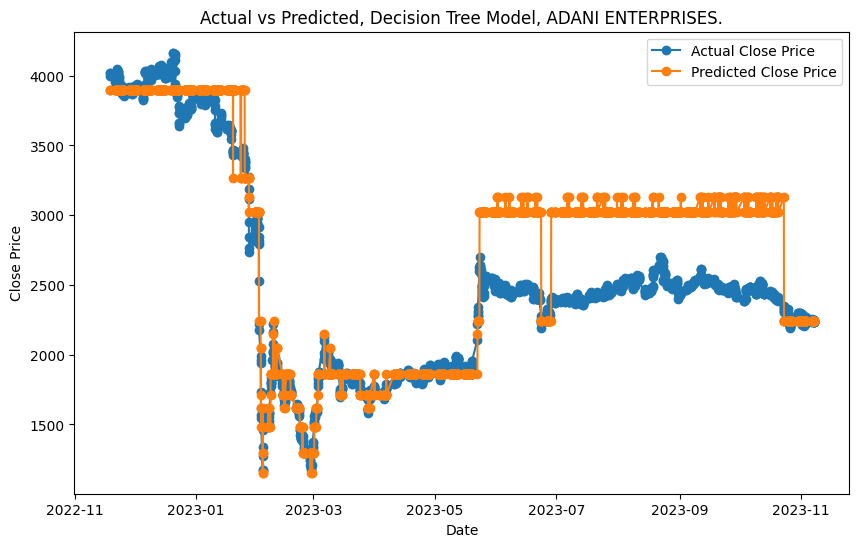

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


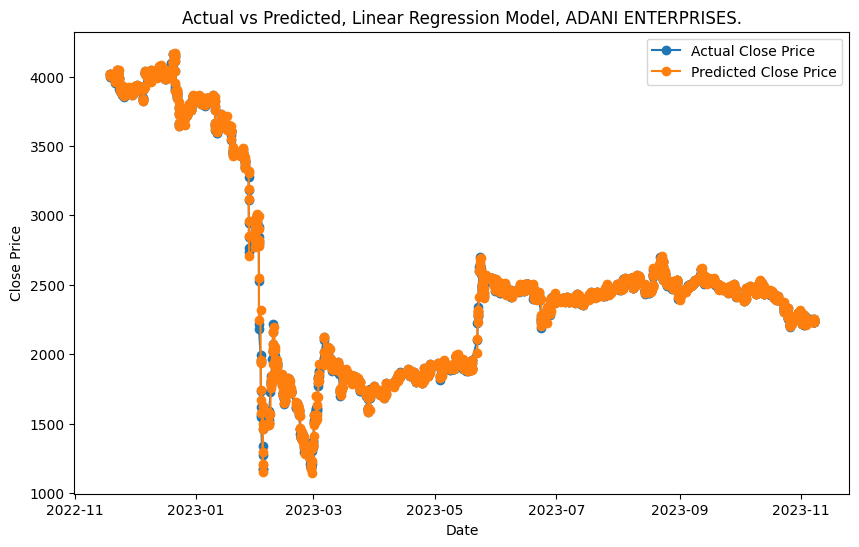

/content/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:175: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


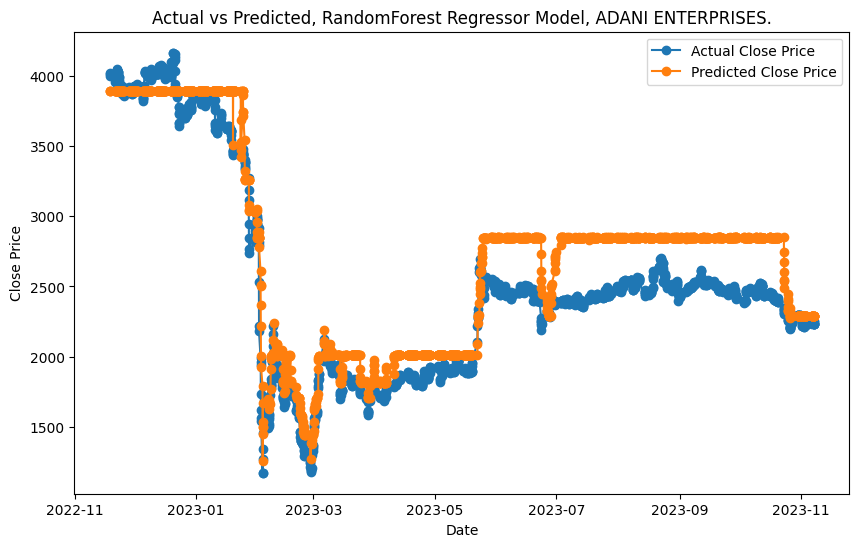

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

model = ["Decision Tree", "Linear Regression", "RandomForest Regressor"]

for company_name in nifty50_companies:
  company = company_name["symbol"]
  if company in models and models[company]:
    for i in range(len(model_names)):
        predictions_pd = all_predictions[company][i].select("date", "close", "prediction").toPandas()

        plt.figure(figsize=(10, 6))
        plt.plot(predictions_pd["date"], predictions_pd["close"], label="Actual Close Price", marker="o")
        plt.plot(predictions_pd["date"], predictions_pd["prediction"], label="Predicted Close Price", marker="o")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Actual vs Predicted, {model[i]} Model, {company}")
        plt.legend()
        plt.show()

**Stop Spark Session**

In [ ]:
# Stop the Spark session when done
spark.stop()